# Slider Puzzle 

#### Solving sliding puzzles using search.

<img src='slidingPuzzle.jpg'>

The goal of this notebook is to walk through how to solve a sliding puzzle algorithmically. Before I can start to solve the puzzle, I need some way to represent it and interact with it. While the puzzle isn't mathematically much like a matrix, it visually resembles one so here's a matrix representation of a sliding puzzle.

In [23]:
%matplotlib inline
import numpy as np
import random, time
import matplotlib.pyplot as plt
import seaborn as sns  # makes plots pretty

In [24]:
def makePuzzle(puzzleSize):
    numbers=range(1, puzzleSize**2+1)
    Bnums=np.array(numbers)
    Tnums=np.array(numbers)
    board=np.reshape(Bnums, (puzzleSize,puzzleSize))
    np.random.shuffle(Tnums)
    tiles=np.reshape(Tnums, (puzzleSize,puzzleSize))
    return board, tiles
    
board,tiles=makePuzzle(3)
print(board)
print(tiles)


[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[5 9 3]
 [8 7 2]
 [6 1 4]]


I start off creating an ordered board and a random tile alignment. The only wrinkle is that `np.random.shuffle` works in place, which necessitates having `Tnums` and `Bnums` as separate variables. 

I'm going to treat the 1 as the blank space, since it exists in all size puzzles. The goal is to move the 1 around until the numbers on the tiles line up with the identical spaces on the board. We'll want to define a function that takes the current tiles and performs a move.

In [25]:
def moveTile(tiles,Xaxis,moveUp): #takes tiles array and two Booleans
    loc=np.where(tiles==1)
    for index in loc:
        x=loc[0].item()
        y=loc[1].item()
    #save values before update
        xP=x
        yP=y
#Update in the right direction unless it takes you off the board
    if Xaxis and moveUp and x<tiles.shape[0]-1:
        x=x+1
    elif Xaxis and not moveUp and x>0:
        x=x-1
    elif not Xaxis and moveUp and y<tiles.shape[0]-1:
        y=y+1
    elif not Xaxis and not moveUp and y>0:
        y=y-1
#switch 1 with Previous value
    tiles[xP][yP]=tiles[x][y]
    tiles[x][y]=1

    return tiles

So I have a board defined and a mechanism for moving tiles. Now I just need an algorithm for how to move the tiles. The naive approach is to do it completely randomly.

## Random Search

In [26]:
for size in range(2,4):
    runstart=time.time()
    board, tiles=makePuzzle(size)
    print('Starting configuration\n', tiles)
    steps=0; match=True
    while not np.array_equal(tiles,board):
        steps+=1
        ##Random update
        Xaxis=bool(random.getrandbits(1))
        moveUp=bool(random.getrandbits(1))
        tiles=moveTile(tiles,Xaxis,moveUp)
        if steps>1000:
            match=False
            break

    if match:
        print('Match\n',tiles,'\n',board,'\n')
    print('Count', steps)
    print('Runtime', (time.time()-runstart) )

Starting configuration
 [[1 4]
 [2 3]]
Match
 [[1 2]
 [3 4]] 
 [[1 2]
 [3 4]] 

Count 40
Runtime 0.0025823116302490234
Starting configuration
 [[8 5 9]
 [2 7 3]
 [6 1 4]]
Count 1001
Runtime 0.021406888961791992


Without the break statment, this cell never finishes. To see why look at the distribution of counts for the 2x2 system.

### The 2x2 Puzzle

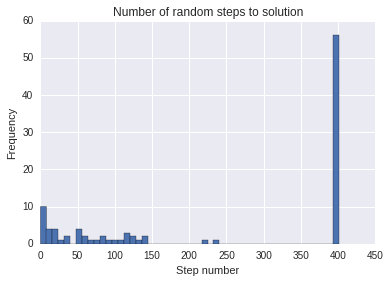

In [27]:
data=[]
for i in range(100):
    board, tiles=makePuzzle(2)
    steps=0
    while not np.array_equal(tiles,board):
        steps+=1
        ##Random update
        Xaxis=bool(random.getrandbits(1))
        moveUp=bool(random.getrandbits(1))
        tiles=moveTile(tiles,Xaxis,moveUp)
        if steps>400:
            break
    data.append(steps)

plt.hist(data, bins=50)
plt.title("Number of random steps to solution")
plt.xlabel("Step number")
plt.ylabel("Frequency")
plt.show()

From the graph it's obvioust that the 2x2 puzzle is not solvable from approximately half of the possible starting configurations. If we throw out the cases where no solution was found we're left with

Median is 24.0


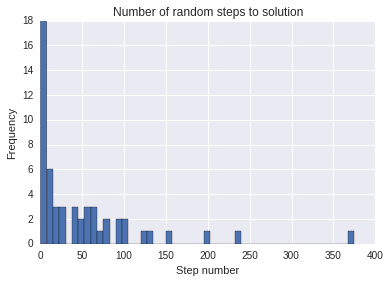

In [28]:
Mdata=[]
for i in range(100):
    board, tiles=makePuzzle(2)
    steps=0; match=True
    while not np.array_equal(tiles,board):
        steps+=1
        ##Random update
        Xaxis=bool(random.getrandbits(1))
        moveUp=bool(random.getrandbits(1))
        tiles=moveTile(tiles,Xaxis,moveUp)
        if steps>400:
            match=False
            break
    if match:
        Mdata.append(steps)
print('Median is', np.median(Mdata))
plt.hist(Mdata, bins=50)
plt.title("Number of random steps to solution")
plt.xlabel("Step number")
plt.ylabel("Frequency")
plt.show()

Under our naive construction there are 4!=24 possible starting states. Any efficient solution to the puzzle should never occupy a state more than once, since removing loops is always more efficient. Since apparently half of those possible states are inaccessible, the maximum number of steps should be a dozen or less. Well under the median value for our naive algorithm.

## Breadth First Search

I can dramatically decrease my search length if I can avoid looking in the same places over and over again. Since I'm looking to have no repetitions, I can represent my search using an undirected acyclic graph, more commonly known as a tree. My tree has branches defined by my possible movements, up/down/left/right and it's height is the number of steps needed to reach the goal state.

The tree can't have more nodes than there are unique states in the puzzle, which implies a limit for the tree's depth.